In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
import os

In [3]:
#os.chdir('/Users/herrakaava/Documents/school/sekamallit/project/graphs')

In [4]:
os.getcwd()

'/Users/herrakaava/Documents/school/sekamallit/project/graphs'

In [2]:
import warnings
warnings.filterwarnings('ignore')

<h3>Read in the data</h3>

In [75]:
df = pd.read_csv('/Users/herrakaava/Documents/school/sekamallit/project/regression_data.csv')

<h3>Exploratory Data Analysis</h3>

In [4]:
df.head()

,bounce_time,age,county,location
0,165.548520,16,devon,a
1,167.559314,34,devon,a
2,165.882952,6,devon,a
3,167.685525,19,devon,a
4,169.959681,34,devon,a


In [5]:
df.shape

(480, 4)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bounce_time  480 non-null    float64
 1   age          480 non-null    int64  
 2   county       480 non-null    object 
 3   location     480 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 15.1+ KB


In [10]:
df.isna().any()

bounce_time    False
age            False
county         False
location       False
dtype: bool

- No missing values.

In [6]:
def convert_obj_to_category(data, features):
    """
    Converts the data type of a variable from 'object' to 'category'.
    
    Args:
    df -- a Pandas DataFrame containing the variable (features)
    features -- the feature(s) that is (are) to be converted from 'object' to 'category'
    
    Returns:
    df -- the modified Pandas DataFrame.
    
    Notes:
    - Data type 'object' is default for string type variables in Python.
    - The input dataframe (df) is modified inplace.
    """
    for var in features:
        data[var] = data[var].astype('category')
    return data

In [7]:
df = convert_obj_to_category(df, ['county', 'location'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   bounce_time  480 non-null    float64 
 1   age          480 non-null    int64   
 2   county       480 non-null    category
 3   location     480 non-null    category
dtypes: category(2), float64(1), int64(1)
memory usage: 9.1 KB


- Notice how the memory usage is more efficient when using 'category' instead of 'object'.

In [14]:
# Visualize the distribution of the response variable
def distr_response(data, save_fig=False, fig_name=None):
    plt.figure(figsize=(8,6))
    ax = sns.histplot(data=data['bounce_time'], kde=True, zorder=2)
    ax.lines[0].set_color('crimson')
    plt.grid(True, zorder=1, alpha=0.3)
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')

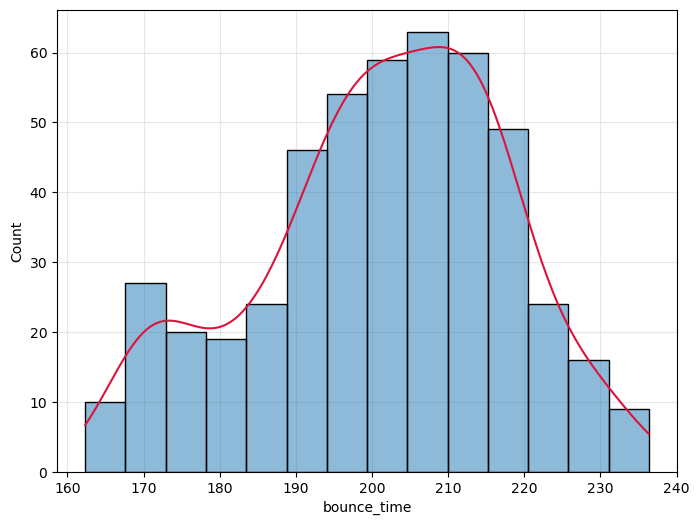

In [15]:
distr_response(data=df, save_fig=True, fig_name='response_distr.png')

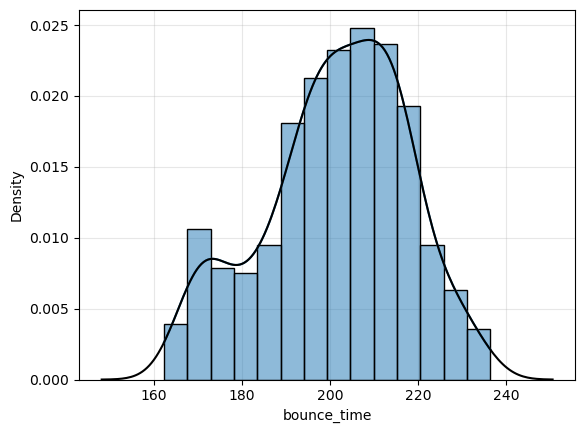

In [12]:
sns.histplot(data=df['bounce_time'], kde=True, stat='density', zorder=2)
sns.kdeplot(df['bounce_time'], color='black', zorder=3)
plt.grid(True, zorder=1, alpha=0.3);

In [52]:
# Visualize the distribution of the age variable
def age_distr(data, save_fig=False, fig_name=None):
    plt.figure(figsize=(8,6), dpi=100)
    sns.histplot(data['age'], bins=12, zorder=1, alpha=0.5)
    plt.grid(True, zorder=1, alpha=0.3);
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')

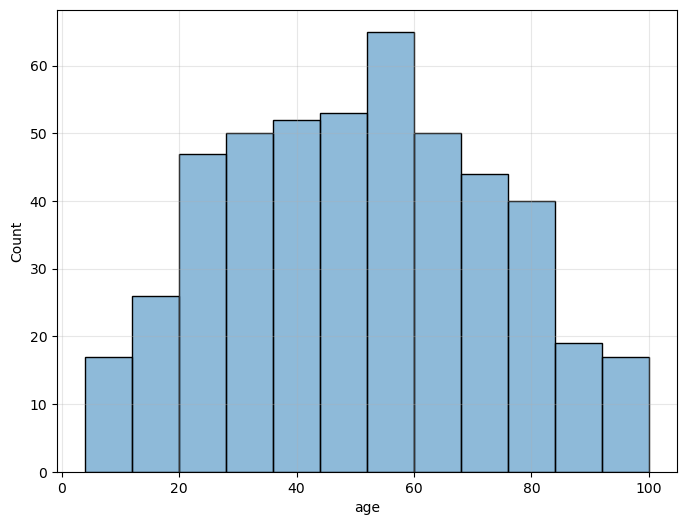

In [53]:
age_distr(data=df, save_fig=True, fig_name='age_distr.png')

<br>

Let's explore some additional relationships.

In [14]:
df['county'].value_counts()

county
cheshire    60
cumbria     60
devon       60
dorset      60
essex       60
kent        60
london      60
norfolk     60
Name: count, dtype: int64

In [15]:
df['location'].value_counts()

location
a    160
b    160
c    160
Name: count, dtype: int64

In [16]:
df.groupby('county')['age'].mean()

county
cheshire    68.716667
cumbria     41.166667
devon       23.583333
dorset      73.250000
essex       65.366667
kent        60.050000
london      31.866667
norfolk     39.800000
Name: age, dtype: float64

In [17]:
df.groupby('county')['bounce_time'].mean()

county
cheshire    219.728421
cumbria     210.687998
devon       179.876946
dorset      199.285572
essex       200.719789
kent        209.275624
london      179.839309
norfolk     211.118032
Name: bounce_time, dtype: float64

In [18]:
pd.DataFrame(df.groupby(['county', 'location'])['bounce_time'].mean())

bounce_time
county   location             
cheshire a          210.202244
         b          219.396124
         c          229.586896
cumbria  a          200.722284
         b          211.189555
         c          220.152155
devon    a          170.097413
         b          178.770648
         c          190.762776
dorset   a          199.976325
         b          199.585208
         c          198.295183
essex    a          190.448489
         b          199.991591
         c          211.719288
kent     a          209.868040
         b          210.936302
         c          207.022531
london   a          171.492906
         b          177.598166
         c          190.426856
norfolk  a          200.590017
         b          212.394117
         c          220.369963

In [54]:
def v(data, save_fig=False, fig_name=None):
    ##### Create unique color for each county in the bar plot #####
    unique_counties = data['county'].unique()
    colors = plt.cm.Accent(range(len(unique_counties)))
    cmap = dict(zip(unique_counties, colors))
    grouped_data = data.groupby(['county', 'location'])['bounce_time'].mean()
    unique_colors = [cmap[county] for county, location in grouped_data.index]

    ##### Plot a bar plot #####
    grouped_data.plot(kind='bar', color=unique_colors, figsize=(8,6))
    plt.ylabel('mean bounce time')
    
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')

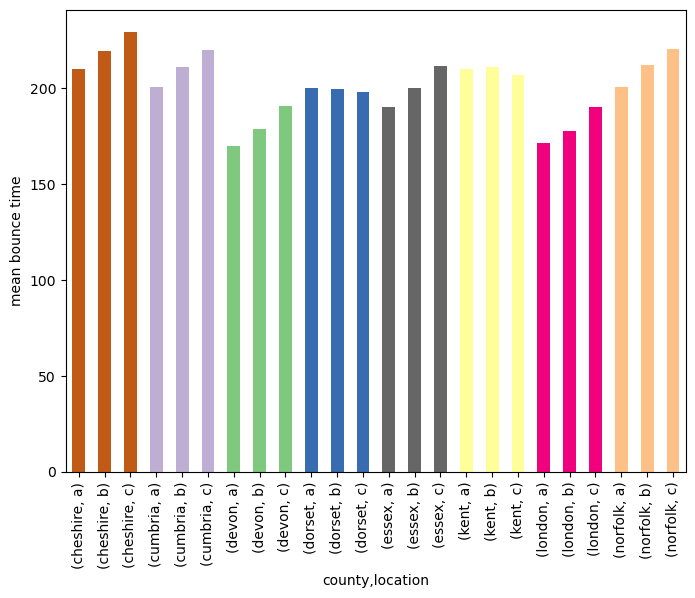

In [66]:
v(data=df)

In [59]:
def age_vs_county(data, save_fig=False, fig_name=None):
    plt.figure(figsize=(8,6), dpi=100)
    sns.boxplot(x='county', y='age', hue='location', data=data, zorder=2)
    legend = plt.legend(bbox_to_anchor=(1,0.7), loc='upper left')
    legend.set_title('Location')
    plt.grid(True, zorder=2, alpha=0.3);
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')

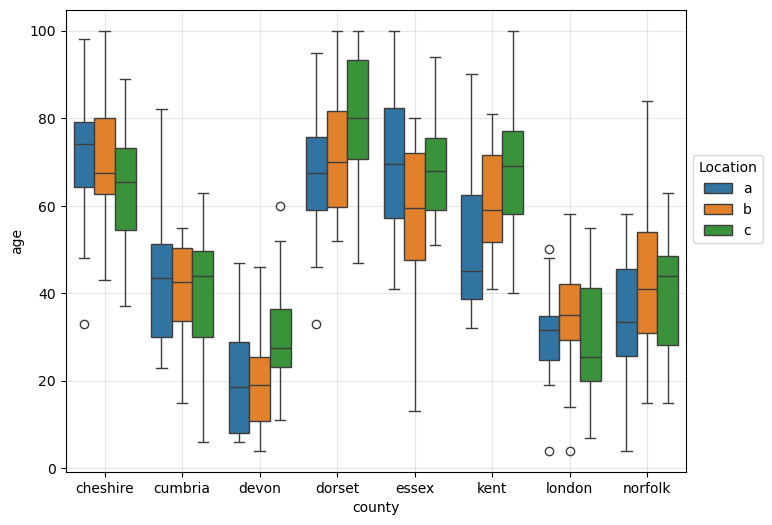

In [60]:
age_vs_county(data=df, save_fig=True, fig_name='age_vs_county.png')

- There seems to be variation in the age groups between the groups and within the groups.

In [63]:
def bounce_vs_county(data, save_fig=False, fig_name=None):
    plt.figure(figsize=(10,6), dpi=100)
    sns.boxplot(x='county', y='bounce_time', hue='location', data=df, zorder=2)
    legend = plt.legend(bbox_to_anchor=(1,0.7), loc='upper left')
    legend.set_title('Location')
    plt.grid(True, zorder=2, alpha=0.3);
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')

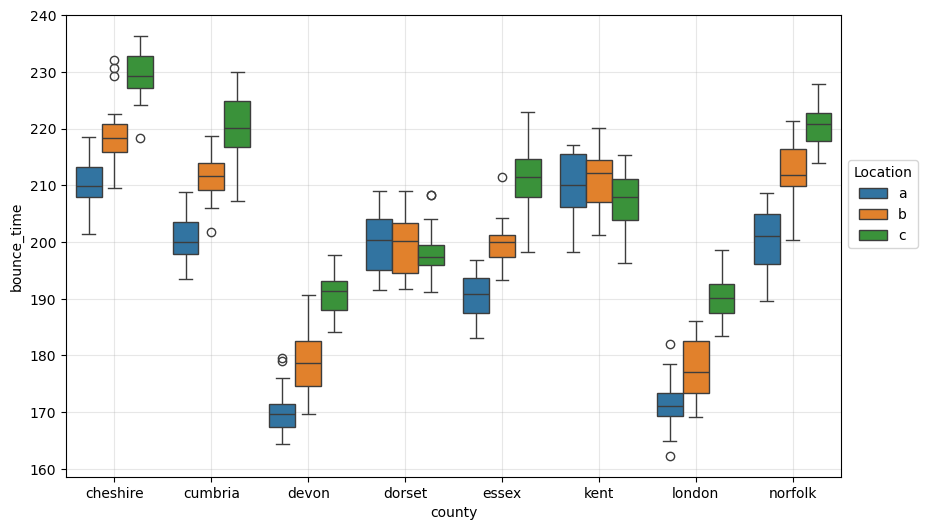

In [65]:
bounce_vs_county(data=df, save_fig=True, fig_name='bounce_vs_county.png')

- Bounce time is clearly not independent of county.

In [2]:
def lm_plot(data, save_fig=False, fig_name=None):
    r = np.round(data.corr(method='pearson').loc['age', 'bounce_time'], 3)
    plt.figure(figsize=(8,6), dpi=100)
    plt.scatter(data['age'], 
                data['bounce_time'], 
                facecolors='none', 
                edgecolors='black')
    plt.annotate(text=f'r = {r}', 
                 xy=(10,235), 
                 xytext=(-15,0), 
                 textcoords='offset points', 
                 fontsize=13);
    # Just your regular simple linear regression model
    model = smf.ols('bounce_time ~ age', data=data)
    fit = model.fit()
    params = fit.params
    r_sq = fit.rsquared
    y_hat = params[0] + params[1] * data['age'].values
    plt.plot(data['age'].values, y_hat, color='blue', linewidth=0.8, label='Best-fit line')
    plt.annotate(text=f'r^2 = {np.round(r**2, 3)}', 
                 xy=(10,235), 
                 xytext=(-34,-16), 
                 textcoords='offset points', 
                 fontsize=13)
    
    ##### Plot the 95% confidence interval for the line #####
    y_preds = fit.get_prediction(data['age'])
    CI_95_y_preds = y_preds.summary_frame(alpha=0.05)
    
    sort_idx = np.argsort(data['age'].values)
    sort_age = data['age'].values[sort_idx]
    sort_ci_lower = CI_95_y_preds['mean_ci_lower'].values[sort_idx]
    sort_ci_upper = CI_95_y_preds['mean_ci_upper'].values[sort_idx]
    
    plt.fill_between(x=sort_age,
                     y1=sort_ci_lower,
                     y2=sort_ci_upper,
                     alpha=0.4,
                     label='95% CI',
                     color='lightblue')
    plt.legend()
    plt.xlabel('Age')
    plt.ylabel('Bounce time')
    
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    
    return fit

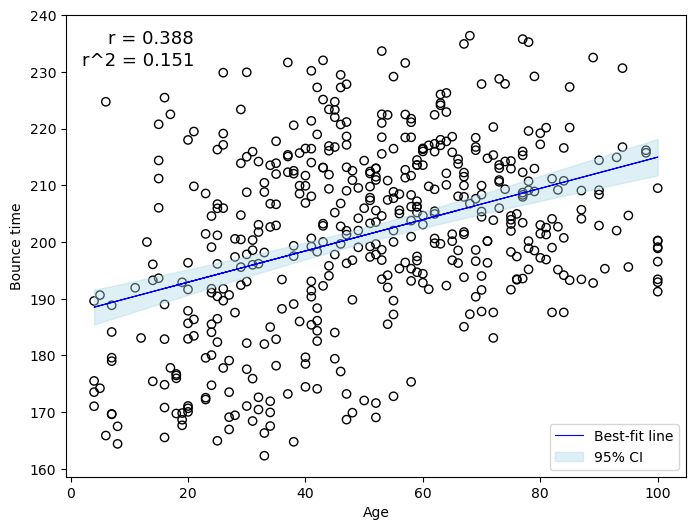

In [68]:
fit_simple_lr = lm_plot(df.loc[:, ['age', 'bounce_time']], save_fig=True, fig_name='lm_plot.png')

In [185]:
print(fit_simple_lr.summary())

                            OLS Regression Results                            
Dep. Variable:            bounce_time   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     84.58
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           1.14e-18
Time:                        11:31:57   Log-Likelihood:                -1978.7
No. Observations:                 480   AIC:                             3961.
Df Residuals:                     478   BIC:                             3970.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    187.4091      1.659    112.951      0.0

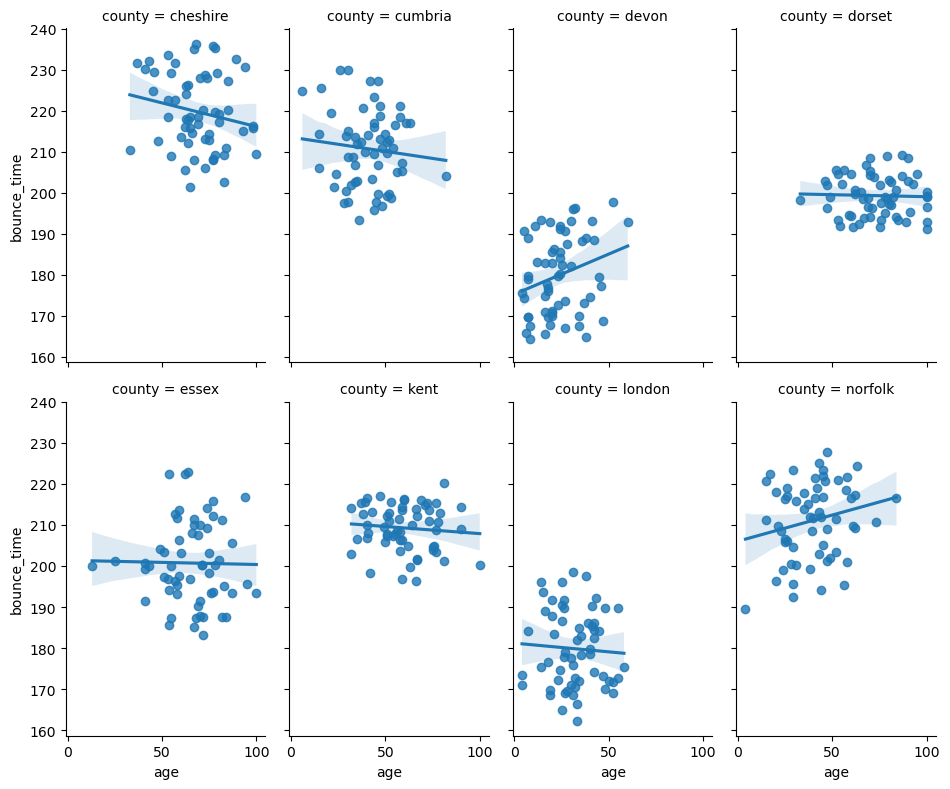

In [171]:
sns.lmplot(x='age', y='bounce_time', col='county', data=df, col_wrap=4, aspect=0.6, height=4)

<h3>Model fitting</h3>

Our research question is that how age affects bounce time, when the effects of 'county' and 'location' is taken into account. We'll model this using a mixed effects model such that we treat **age** as a *fixed* effect, and **county** and **location** as *random* effects.

\begin{equation*}
    \large y_{ijk} = \beta_0 \, + \, \beta_1 age_i \, + \, b_{1j} \, + \, b_{2k} \, + \, \epsilon_{ijk}
\end{equation*}

where

$$ b_{1j} \sim N(0, \tau_1^2) $$
$$ b_{2k} \sim N(0, \tau_2^2) $$
$$ \epsilon_{ijk} \sim N(0, \sigma^2) $$

are all independent of each other.

This is a **random intercept model**.

In [71]:
def mixed_effects_model_1(data):
    """
    Builds and fits a mixed effects model, where bounce_time is the response,
    age is a fixed effect, and county and location are random effects.
    """
    model = smf.mixedlm(
        formula='bounce_time ~ age',
        data=data,
        groups='county',
        re_formula='1', 
        vc_formula={'location': '0 + C(location)'}
    )
    fit = model.fit(reml=True)
    return model, fit

re_formula='1':

- Random intercept for each group (of the variable specified with the 'groups' parameter).
- Note that we don't need to specify this, since the default behavior without any additional specifications is that a random intercept is given for each level of the grouping variable.

vc_formula:

- To specify additional random effects, one has to specify them via the vc_formula (variance components formula).
- Unlike in R, we cannot specify all the random effects inside the 'formula' parameter.
- {'location': '0 + C(location)'} adds a random intercept for the 'location' variable.

In [72]:
m1, f1 = mixed_effects_model_1(df)

In [73]:
print(f1.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: bounce_time
No. Observations:  480     Method:             REML       
No. Groups:        8       Scale:              23.9924    
Min. group size:   60      Log-Likelihood:     -1501.7257 
Max. group size:   60      Converged:          Yes        
Mean group size:   60.0                                   
----------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    201.162    5.248 38.331 0.000 190.876 211.448
age            0.003    0.016  0.190 0.849  -0.028   0.034
county Var   189.792   23.711                             
location Var  74.688    5.573                             



- Notice how the effect of 'age' gets significantly smaller when accounting for the variation included in 'county' and 'location' (compared to the simple linear regression).

$\large\boldsymbol{\sigma^2}$:

In [8]:
np.sqrt(f1.scale)

4.898200663802121

$\large\boldsymbol{\tau_1^2}$:

In [9]:
np.sqrt(f1.cov_re.values.ravel()[0])

13.776501772794843

$\large\boldsymbol{\tau_2^2}$:

In [10]:
np.sqrt(f1.vcomp[0])

8.642196288410773

<h3>Diagnostics</h3>

In [12]:
def resid_scatter(f, method, x_var, return_eps=False, save_fig=False, fig_name=None):
    """
    Plots one of the two graphs; 
        1. residuals vs. index
        2. residuals vs. fitted values
    The formula for Pearson residuals is:
        r_i = (y_i - hat{y_i}) / sigma,
    where sigma is the standard deviation of the residuals.
    
    Args:
    f -- a fitted (statsmodels) model
    method -- Method to use; options include 'raw' and 'pearson'
    x_var -- specifies what to plot in the x-axis; options include 'index', 'fitted_vals'
    return_eps -- whether to return the residuals (bool)
    
    Returns:
    resid -- the pearson residuals.
    
    Notes:
    - The fitted values reflect the mean structure specified by the fixed effects 
      and the predicted random effects.
    """
    method = method.lower()
    x_var = x_var.lower()
    assert method in ['raw', 'pearson']
    assert x_var in ['index', 'fitted_vals']
    
    if method == 'raw':
        residuals = f.resid
    elif method == 'pearson':
        residuals = f.resid / np.sqrt(f1.scale)
        
    if x_var == 'index':
        x = np.arange(residuals.shape[0])
        x_label = 'index'
    if x_var == 'fitted_vals':
        x = f.fittedvalues
        x_label = 'fitted values'
    
    ##### Plotting #####
    plt.figure(figsize=(8,6), dpi=100)
    plt.scatter(x, residuals, facecolors='none', edgecolors='black')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel(x_label)
    
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')
    
    if return_eps:
        return residuals

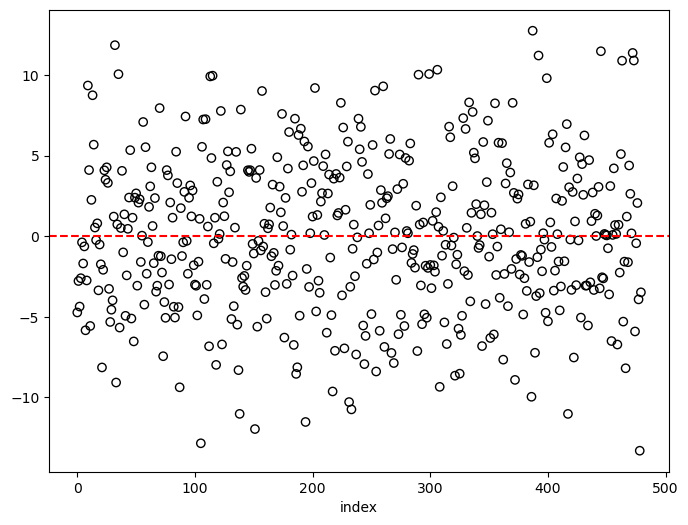

In [13]:
eps = resid_scatter(f1, 
                    method='raw', 
                    x_var='index', 
                    return_eps=True, 
                    save_fig=True, 
                    fig_name='raw_resid_vs_index.png')

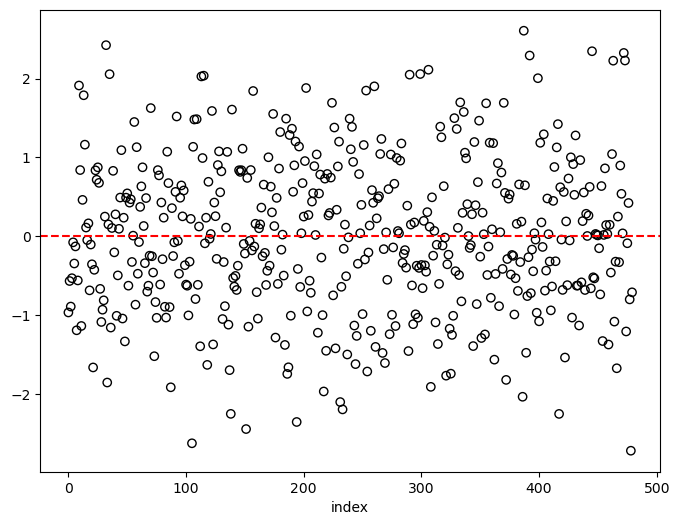

In [14]:
eps = resid_scatter(f1, 
                    method='pearson', 
                    x_var='index', 
                    return_eps=True, 
                    save_fig=True, 
                    fig_name='raw_resid_vs_index.png')

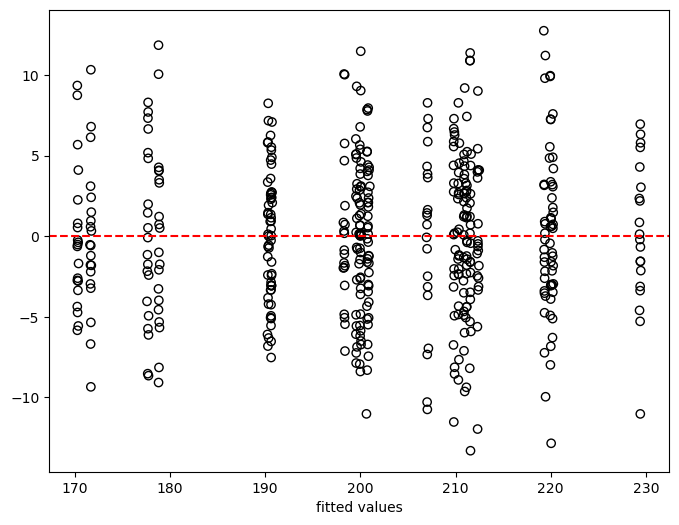

In [15]:
resid_scatter(f1, 
              method='raw', 
              x_var='fitted_vals',
              return_eps=False,
              save_fig=True,
              fig_name='raw_resid_vs_fitted_vals.png')

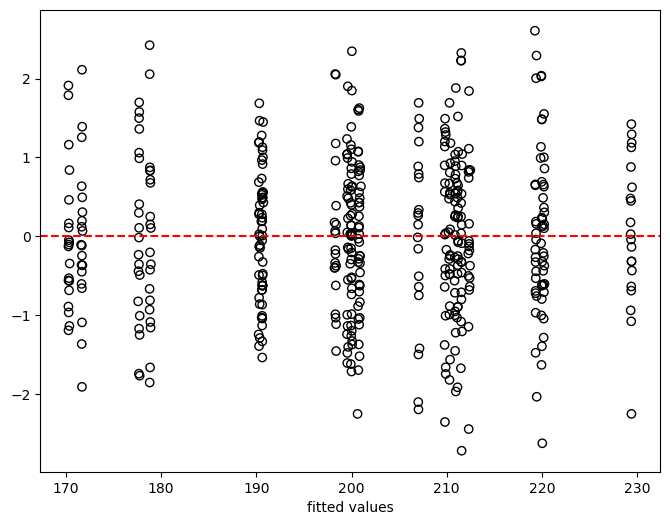

In [16]:
resid_scatter(f1, 
              method='pearson', 
              x_var='fitted_vals',
              return_eps=False,
              save_fig=True,
              fig_name='raw_resid_vs_fitted_vals.png')

- No visible patterns (although those gaps between the predictions are weird. Why the predictions take consistently such high jumps?)

In [23]:
np.sort(df.loc[:, 'bounce_time'].values)[:, np.newaxis]

array([[162.3266403],
       [164.4162728],
       [164.7812478],
       [164.9587105],
       [165.5485196],
       [165.8829517],
       [166.3266633],
       [166.9571182],
       [167.5104297],
       [167.5593135],
       [167.6855249],
       [168.4443179],
       [168.6704394],
       [168.6887472],
       [169.0762543],
       [169.1192163],
       [169.4562011],
       [169.6193817],
       [169.7087779],
       [169.7708317],
       [169.8457111],
       [169.9158692],
       [169.9596807],
       [170.0534398],
       [170.464896 ],
       [170.6868505],
       [170.8193187],
       [171.0507305],
       [171.0892154],
       [171.0932718],
       [171.6060259],
       [171.933489 ],
       [172.0604235],
       [172.2301887],
       [172.5594668],
       [172.6260848],
       [172.8035081],
       [173.2164322],
       [173.2164946],
       [173.5323951],
       [173.5325881],
       [174.1197927],
       [174.2216996],
       [174.4654852],
       [174.7524868],
       [17

- The original bounce times do not take such jumps? Mitä helvettiä

In [28]:
np.sort(f1.fittedvalues.values)[:, np.newaxis]

array([[170.24934259],
       [170.25259167],
       [170.25259167],
       [170.25259167],
       [170.25584076],
       [170.25584076],
       [170.28183344],
       [170.28183344],
       [170.28833161],
       [170.28833161],
       [170.2915807 ],
       [170.29482978],
       [170.29482978],
       [170.30457704],
       [170.31757338],
       [170.34031698],
       [170.34031698],
       [170.35331332],
       [170.35981149],
       [170.38255509],
       [171.58250105],
       [171.63123733],
       [171.63123733],
       [171.64423368],
       [171.64748276],
       [171.65073185],
       [171.65398093],
       [171.6604791 ],
       [171.66697728],
       [171.67022636],
       [171.67347545],
       [171.67347545],
       [171.67672453],
       [171.67672453],
       [171.67672453],
       [171.69946813],
       [171.7059663 ],
       [171.72221173],
       [171.72546082],
       [171.73195899],
       [177.57688158],
       [177.60937243],
       [177.62236877],
       [177

**Assessing normality of the residuals**

In [74]:
def QQ_plot(x, save_fig=False, fig_name=None):
    pp = sm.ProbPlot(x, fit=True)
    qq = pp.qqplot(marker='o', markerfacecolor='none', markeredgecolor='black', alpha=0.4)
    sm.qqline(qq.axes[0], line='45', fmt='r--', linewidth=1.4)
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')

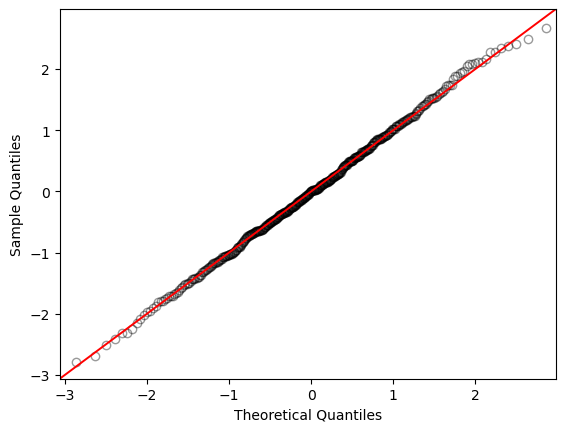

In [75]:
QQ_plot(eps, save_fig=True, fig_name='QQ_plot_raw_residuals.png')

- Definitely normally distributed I would say.

In [ ]:
sm.qqplot()

**Assessing the normality of the predictions of the random effects**

In [48]:
def random_effects_preds(f):
    re = f.random_effects
    county = [val.iloc[0] for key, val in re.items()]
    loc_a = [val.iloc[1] for key, val in re.items()]
    loc_b = [val.iloc[2] for key, val in re.items()]
    loc_c = [val.iloc[3] for key, val in re.items()]
    DF = pd.DataFrame({
        'county': county,
        'loc_a': loc_a,
        'loc_b': loc_b,
        'loc_c': loc_c
    }, index=re.keys())
    return DF

In [49]:
re_preds = random_effects_preds(f1)

In [50]:
print(re_preds)

             county      loc_a     loc_b      loc_c
cheshire  15.880711  -6.950837  2.097821  12.151946
cumbria    8.135426  -8.566045  1.742628  10.562537
devon    -18.476158 -12.446458 -3.908631   7.863266
dorset    -1.821374   0.420481  0.020824  -1.278426
essex     -0.558172 -10.208290 -0.777706  10.729455
kent       6.860199   1.664772  2.682442  -1.194200
london   -18.532013 -11.050946 -5.056566   7.590019
norfolk    8.511380  -9.043862  2.548249  10.407526


In [352]:
i = 1
for key, val in f1.random_effects.items():
    print(f'##### This is the key number {i}: {key} #####')
    print(f'These are the values of the key number {i}:')
    print(val)
    print()
    i += 1

##### This is the key number 1: cheshire #####
These are the values of the key number 1:
county                      15.880711
location[C(location)[a]]    -6.950837
location[C(location)[b]]     2.097821
location[C(location)[c]]    12.151946
dtype: float64

##### This is the key number 2: cumbria #####
These are the values of the key number 2:
county                       8.135426
location[C(location)[a]]    -8.566045
location[C(location)[b]]     1.742628
location[C(location)[c]]    10.562537
dtype: float64

##### This is the key number 3: devon #####
These are the values of the key number 3:
county                     -18.476158
location[C(location)[a]]   -12.446458
location[C(location)[b]]    -3.908631
location[C(location)[c]]     7.863266
dtype: float64

##### This is the key number 4: dorset #####
These are the values of the key number 4:
county                     -1.821374
location[C(location)[a]]    0.420481
location[C(location)[b]]    0.020824
location[C(location)[c]]   -1.27842

In [48]:
def re_QQ_plot(data, save_fig=False, fig_name=None):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8), dpi=100)
    ax = ax.ravel()
    
    for i, re in enumerate(data):
        pp = sm.ProbPlot(data[re], fit=True)
        qq = pp.qqplot(marker='o', 
                       markerfacecolor='none', 
                       markeredgecolor='black', 
                       alpha=0.4,
                       ax=ax[i])
        sm.qqline(ax[i], line='45', fmt='r--', linewidth=1.4, label=re)
        
        if re == 'loc_a':
            ax[i].set_xlim([-1.3, 1.9])
            ax[i].set_ylim([-1.3, 1.9])
            ax[i].set_xlabel('')
            ax[i].set_ylabel('')
            ax[i].annotate(text=re,
                           xy=(-1,1.5),
                           xytext=(1,1),
                           textcoords='offset points',
                           fontsize=12)
        if re == 'county':
            ax[i].set_xlabel('')
        if re == 'loc_c':
            ax[i].set_ylabel('')
        
        if re != 'loc_a':
            ax[i].annotate(text=re,
                           xy=(-1.5,1),
                           xytext=(1,1),
                           textcoords='offset points',
                           fontsize=12)
            
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')

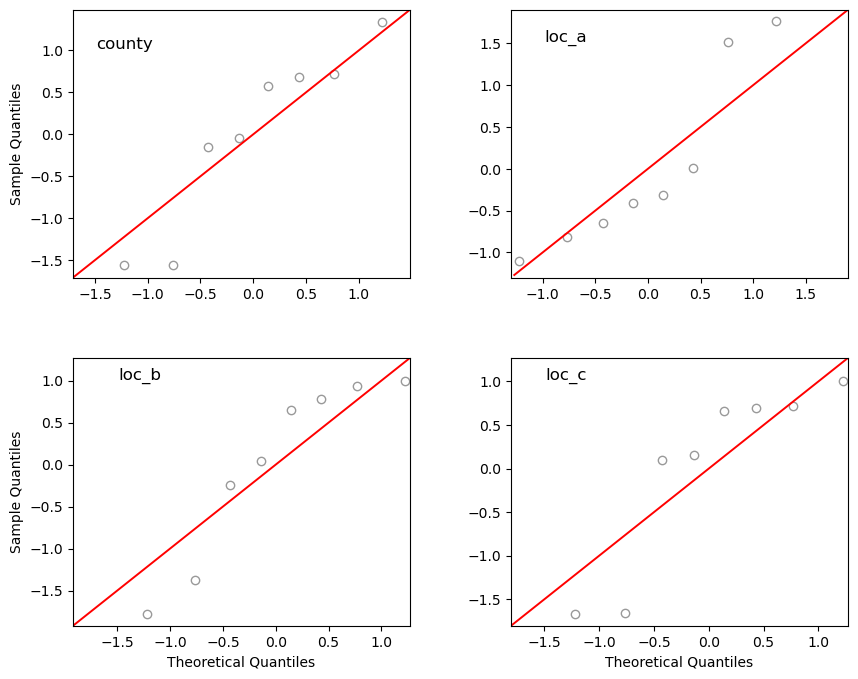

In [49]:
re_QQ_plot(re_preds, save_fig=False, fig_name='re_QQ_plot.png')

Perhaps we'll also look at them all together in the same QQ-plot.

In [70]:
def re_QQ_plot_2(data, save_fig=False, fig_name=None):
    #plt.figure(figsize=(8,6), dpi=100)
    pp = sm.ProbPlot(data, fit=True)
    qq = pp.qqplot(marker='o',
                   markerfacecolor='none',
                   markeredgecolor='black',
                   alpha=0.4)
    sm.qqline(qq.axes[0], line='45', fmt='r--')
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')

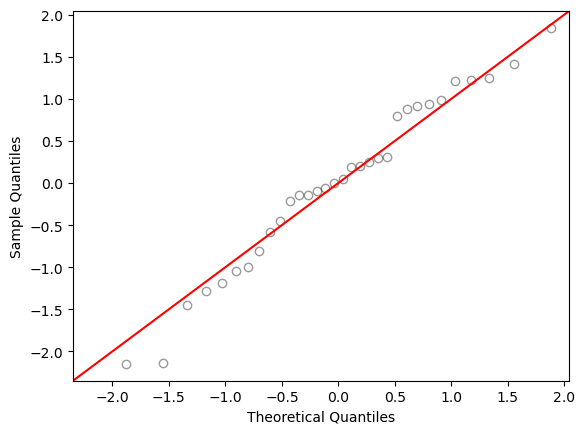

In [71]:
re_QQ_plot_2(re_preds.values.ravel(), save_fig=True, fig_name='re_QQ_plot_combined.png')

- Miks tää näyttää paremmalta?

**Scatter plots of the random effects**

In [51]:
def re_scatter(x, save_fig=False, fig_name=None):
    """
    Args:
    x -- the random effects predictions
    """
    plt.figure(figsize=(8,6), dpi=100)
    x_vals = x.index
    for feature in x.columns:
        plt.scatter(x_vals, x[feature], facecolors='none', edgecolors='black')
    plt.axhline(y=0, color='red', linestyle='--')
    if save_fig:
        if fig_name is None:
            raise ValueError('fig_name must be provided if save_fig is True')
        plt.savefig(fig_name, format='png', bbox_inches='tight')

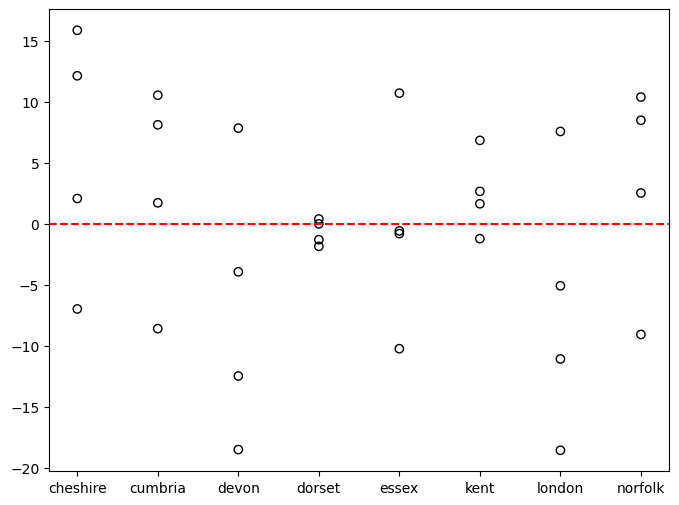

In [52]:
re_scatter(re_preds, save_fig=True, fig_name='re_scatter.png')

<br>

<h2>Redoing the analysis again using R</h2>

I Noticed that the results of the random effects model differ from the one given in R. This is probably due to the fact that statsmodels does not support directly adding more than one random effects into a model (e.g., a random intercept model with random intercepts for county and location). I managed to get the same results using the help posted on this [stackoverflow](https://stackoverflow.com/questions/59359568/from-2d-to-1d-how-to-pass-a-second-random-effect-in-mixed-model-python-statsm) post, as displayed below. However, using this method, we get a convergence warning regarding the hessian matrix, which is used to estimate the standard errors of the parameter estimates. Knowing this, it is not surprising that python gives different standard error for the parameters than R.

In [2]:
df = pd.read_csv('/Users/herrakaava/Documents/school/sekamallit/project/regression_data.csv')

In [3]:
def convert_obj_to_category(data, features):
    """
    Converts the data type of a variable from 'object' to 'category'.
    
    Args:
    df -- a Pandas DataFrame containing the variable (features)
    features -- the feature(s) that is (are) to be converted from 'object' to 'category'
    
    Returns:
    df -- the modified Pandas DataFrame.
    
    Notes:
    - Data type 'object' is default for string type variables in Python.
    - The input dataframe (df) is modified inplace.
    """
    for var in features:
        data[var] = data[var].astype('category')
    return data

In [4]:
df = convert_obj_to_category(df, ['county', 'location'])

In [11]:
def test_fit(data):
    # Dummy grouping variable
    data['group'] = 1
    vcf = {
        'location': '0 + C(location)',
        'county': '0 + C(county)'
    }
    model = smf.mixedlm('bounce_time ~ age',
                        data=data,
                        groups='group',
                        vc_formula=vcf,
                        re_formula='~1')
    fit = model.fit(reml=True)
    return model, fit

In [12]:
test_model, test_fit = test_fit(df)

/Users/herrakaava/anaconda3/envs/sekamallit/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [13]:
print(test_fit.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: bounce_time
No. Observations:  480     Method:             REML       
No. Groups:        1       Scale:              39.3614    
Min. group size:   480     Log-Likelihood:     -1590.8042 
Max. group size:   480     Converged:          Yes        
Mean group size:   480.0                                  
----------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    203.571    9.320 21.843 0.000 185.304 221.837
age           -0.045    0.020 -2.271 0.023  -0.083  -0.006
group Var     39.361                                      
county Var   230.641   19.881                             
location Var  52.800    8.478                             



In [14]:
# Standard errors of the fixed effects
test_fit.bse_fe

Intercept    9.319810
age          0.019667
dtype: float64

In [67]:
test_fit.random_effects

{1: group                          1.149232e-10
 county[C(county)[cheshire]]    1.917216e+01
 county[C(county)[cumbria]]     8.930393e+00
 county[C(county)[devon]]      -2.257638e+01
 county[C(county)[dorset]]     -1.010804e+00
 county[C(county)[essex]]       6.824725e-02
 county[C(county)[kent]]        8.363028e+00
 county[C(county)[london]]     -2.224499e+01
 county[C(county)[norfolk]]     9.298341e+00
 location[C(location)[a]]      -7.197816e+00
 location[C(location)[b]]      -9.808557e-02
 location[C(location)[c]]       7.295902e+00
 dtype: float64}

In [68]:
# This model is fitted below, but the print is shown here to compare the results
%%R
ranef(fit)

$county
          (Intercept)
cheshire  19.17217909
cumbria    8.93039514
devon    -22.57639583
dorset    -1.01079805
essex      0.06825135
kent       8.36303522
london   -22.24500965
norfolk    9.29834273

$location
  (Intercept)
a -7.19779856
b -0.09808541
c  7.29588397

with conditional variances for “county” “location” 


In [74]:
# Random effects from the first model fitted previously using Python
f1.random_effects

{'cheshire': county                      16.197411
 location[C(location)[a]]    -7.258370
 location[C(location)[b]]     1.790023
 location[C(location)[c]]    11.842404
 dtype: float64,
 'cumbria': county                       8.294479
 location[C(location)[a]]    -8.723862
 location[C(location)[b]]     1.584107
 location[C(location)[c]]    10.403825
 dtype: float64,
 'devon': county                     -18.845585
 location[C(location)[a]]   -12.088176
 location[C(location)[b]]    -3.550693
 location[C(location)[c]]     8.222695
 dtype: float64,
 'dorset': county                     -1.853448
 location[C(location)[a]]    0.455203
 location[C(location)[b]]    0.056435
 location[C(location)[c]]   -1.241013
 dtype: float64,
 'essex': county                      -0.566650
 location[C(location)[a]]   -10.195992
 location[C(location)[b]]    -0.767962
 location[C(location)[c]]    10.740965
 dtype: float64,
 'kent': county                      6.997297
 location[C(location)[a]]    1.529786
 loc

- It seems that these are wrong as well.
- The model should include only one random effect per county and location, not one random effect per location **within** a county.

In [21]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import rpy2

In [84]:
%%R
install.packages('dplyr')

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Guangzhou) [https]
20: China (Jinan) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: France (Lyon 1) [https]
33: France (Lyon 2) [https]
34: France (Marseille

R[write to console]: also installing the dependencies ‘generics’, ‘tidyselect’


R[write to console]: trying URL 'https://ftp.gwdg.de/pub/misc/cran/src/contrib/generics_0.1.3.tar.gz'

R[write to console]: Content type 'application/octet-stream'
R[write to console]:  length 172201 bytes (168 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

arm64-apple-darwin20.0.0-clang++ -std=gnu++17 -I"/Users/herrakaava/anaconda3/envs/sekamallit/lib/R/include" -DNDEBUG   -D_FORTIFY_SOURCE=2 -isystem /Users/herrakaava/anaconda3/envs/sekamallit/include -mmacosx-version-min=11.0 -mmacosx-version-min=11.0 -I/Users/herrakaava/anaconda3/envs/sekamallit/include    -fPIC  -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -stdlib=libc++ -fvisibility-inlines-hidden -fmessage-length=0 -isystem /Users/herrakaava/anaconda3/envs/sekamallit/include -fdebug-prefix-map=/Users/runner/miniforge3/conda-bld/r-base-split_1723488734796/work=/usr/local/src/conda/r-base-4.3.3 -fdebug-prefix-map=/Users/herrakaava/anaconda3/envs/sekamallit=/usr/local/src/conda-prefix  -c chop.cpp -o chop.o
arm64-apple-darwin20.0.0-clang++ -std=gnu++17 -I"/Users/herrakaava/anaconda3/envs/sekamallit/lib/R/include" -DNDEBUG   -D_FORTIFY_SOURCE=2 -isystem /Users/herrakaava/anaconda3/envs/sekamallit/include -mmacosx-version-min=11.0 -mmacosx-version-min=11.0 -I/Users/herrakaa

arm64-apple-darwin20.0.0-clang++ -std=gnu++17 -dynamiclib -Wl,-headerpad_max_install_names -undefined dynamic_lookup -L/Users/herrakaava/anaconda3/envs/sekamallit/lib/R/lib -Wl,-dead_strip_dylibs -Wl,-headerpad_max_install_names -Wl,-dead_strip_dylibs -Wl,-rpath,/Users/herrakaava/anaconda3/envs/sekamallit/lib -L/Users/herrakaava/anaconda3/envs/sekamallit/lib -o dplyr.dylib chop.o filter.o funs.o group_by.o group_data.o imports.o init.o mask.o mutate.o reconstruct.o slice.o summarise.o -L/Users/herrakaava/anaconda3/envs/sekamallit/lib/R/lib -lR -Wl,-framework -Wl,CoreFoundation


installing to /Users/herrakaava/anaconda3/envs/sekamallit/lib/R/library/00LOCK-dplyr/00new/dplyr/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (dplyr)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/private/var/folders/rc/8fy4h_gj15d1n500pf9nmvnw0000gn/T/RtmpT5XhwU/downloaded_packages’
R[write to console]: 
R[write to console]: 

R[write to console]: Updating HTML index of packages in '.Library'

R[write to console]: Making 'packages.html' ...
R[write to console]:  done



In [22]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [86]:
%%R
library(nlme)
library(lme4)
library(MASS)
library(ggplot2)
library(dplyr)

In [26]:
def convert_pandas_2_R():
    # Activate the automatic conversion of pandas DataFrames to R dataframes
    pandas2ri.activate()

    # Convert Python's DataFrame to R data.frame
    r_df = pandas2ri.py2rpy(df)

    # Assign the converted dataframe to the R environment
    ro.globalenv['r_df'] = r_df

In [28]:
convert_pandas_2_R()

In [29]:
%%R
head(r_df)

  bounce_time age county location group
0    165.5485  16  devon        a     1
1    167.5593  34  devon        a     1
2    165.8830   6  devon        a     1
3    167.6855  19  devon        a     1
4    169.9597  34  devon        a     1
5    168.6887  47  devon        a     1


In [46]:
%%R
for (col in colnames(r_df)) {
    cat(class(r_df[[col]]), '\n')
}

numeric 
integer 
factor 
factor 
integer 


In [50]:
%%R
fit <- lmer(bounce_time ~ age + (1|location) + (1|county), REML=TRUE, data=r_df)
summary(fit)

Linear mixed model fit by REML ['lmerMod']
Formula: bounce_time ~ age + (1 | location) + (1 | county)
   Data: r_df

REML criterion at convergence: 3181.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1877 -0.6283  0.0099  0.6197  2.8047 

Random effects:
 Groups   Name        Variance Std.Dev.
 county   (Intercept) 230.69   15.188  
 location (Intercept)  52.77    7.264  
 Residual              39.36    6.274  
Number of obs: 480, groups:  county, 8; location, 3

Fixed effects:
             Estimate Std. Error t value
(Intercept) 203.57086    6.89130  29.540
age          -0.04466    0.01963  -2.275

Correlation of Fixed Effects:
    (Intr)
age -0.144


In [51]:
print(test_fit.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: bounce_time
No. Observations:  480     Method:             REML       
No. Groups:        1       Scale:              39.3614    
Min. group size:   480     Log-Likelihood:     -1590.8042 
Max. group size:   480     Converged:          Yes        
Mean group size:   480.0                                  
----------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    203.571    9.320 21.843 0.000 185.304 221.837
age           -0.045    0.020 -2.271 0.023  -0.083  -0.006
group Var     39.361                                      
county Var   230.641   19.881                             
location Var  52.800    8.478                             



- As can be seen, the results are otherwise similar, but R does not give the corvengence warning, and therefore probably is estimating the hessian matrix (and standard errors) correctly.
- We'll conduct the model diagnostics again using R.

In [79]:
%%R
resid_scaled <- resid(fit, scaled = TRUE)
resid_unscaled <- resid(fit)
fitted_vals <- fitted(fit)
random_effects = ranef(fit)

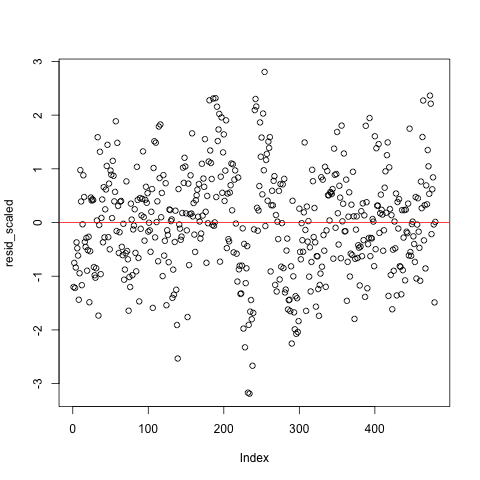

In [80]:
%%R
plot(resid_scaled)
abline(h=0, col='red')

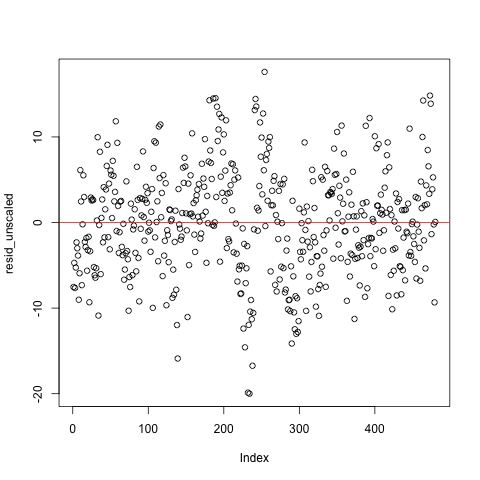

In [81]:
%%R
plot(resid_unscaled)
abline(h=0, col='red')

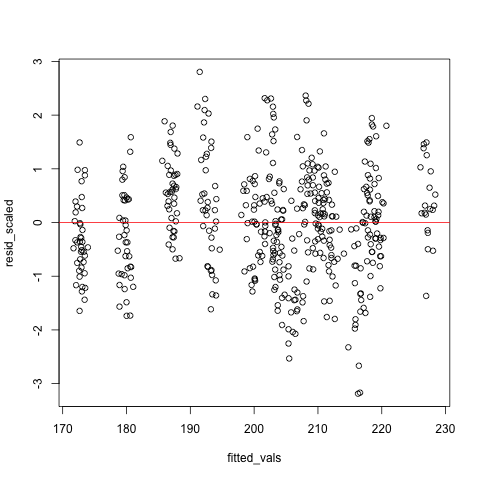

In [103]:
%%R
plot(fitted_vals, resid_scaled)
abline(h=0, col='red')

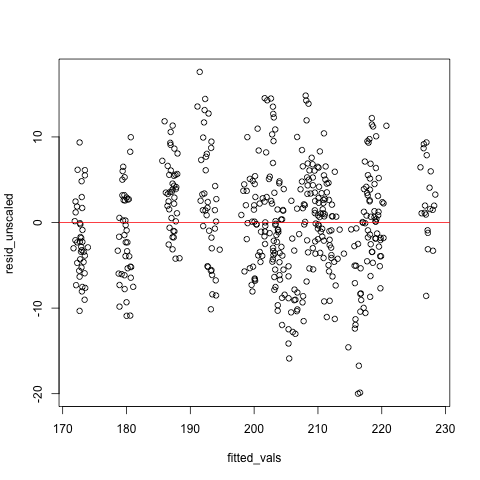

In [104]:
%%R
plot(fitted_vals, resid_unscaled)
abline(h=0, col='red')

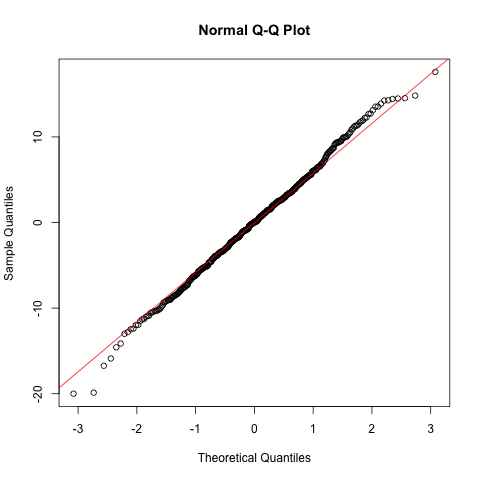

In [63]:
%%R
qqnorm(resid)
qqline(resid, col='red')

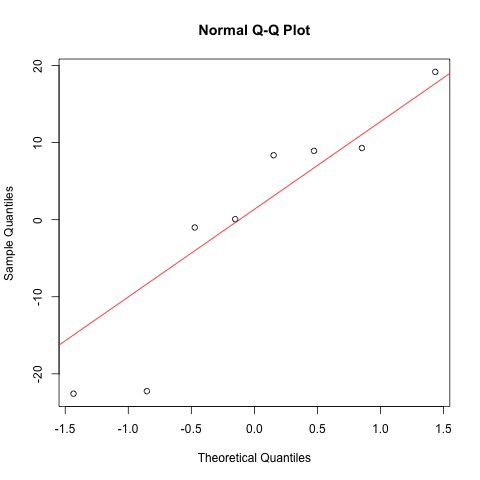

In [109]:
%%R
re_county <- random_effects$'county'$'(Intercept)'
qqnorm(re_county)
qqline(re_county, col='red')

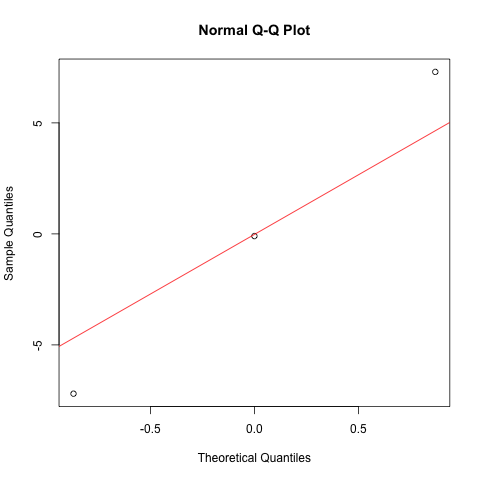

In [117]:
%%R
re_location <- random_effects$'location'$'(Intercept)'
qqnorm(re_location)
qqline(re_location, col='red')

In [123]:
%%R
combined_re <- c(re_county, re_location)
combined_re

 [1]  19.17217909   8.93039514 -22.57639583  -1.01079805   0.06825135
 [6]   8.36303522 -22.24500965   9.29834273  -7.19779856  -0.09808541
[11]   7.29588397


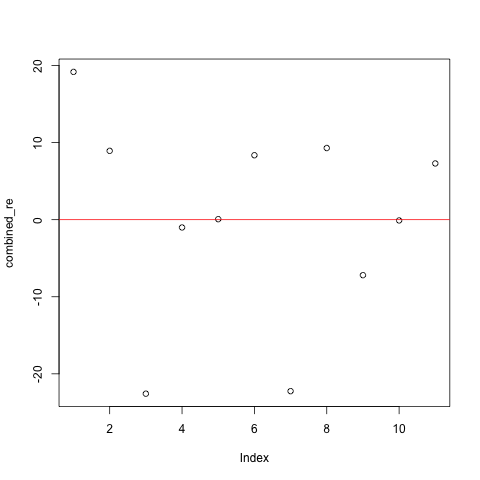

In [127]:
%%R
plot(combined_re)
abline(h=0, col='red')

<br>

In [145]:
%%R
#install.packages('lmerTest')

NULL


In [147]:
%%R
#library(lmerTest)

NULL


In [148]:
%%R
fit <- lmer(bounce_time ~ age + (1|location) + (1|county), REML=TRUE, data=r_df)
summary(fit)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: bounce_time ~ age + (1 | location) + (1 | county)
   Data: r_df

REML criterion at convergence: 3181.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1877 -0.6283  0.0099  0.6197  2.8047 

Random effects:
 Groups   Name        Variance Std.Dev.
 county   (Intercept) 230.69   15.188  
 location (Intercept)  52.77    7.264  
 Residual              39.36    6.274  
Number of obs: 480, groups:  county, 8; location, 3

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 203.57086    6.89130   8.16415  29.540 1.37e-09 ***
age          -0.04466    0.01963 472.35946  -2.275   0.0234 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
age -0.144


In [154]:
%%R
confint(fit, oldNames = FALSE)

R[write to console]: Computing profile confidence intervals ...



             [,1]          [,2]
[1,]   9.45787939  26.231230194
[2,]   3.34761151  20.895107200
[3,]   5.88697166   6.690301432
[4,] 189.29004319 217.891133573
[5,]  -0.08299836  -0.005834428


                               2.5 %        97.5 %
sd_(Intercept)|county     9.45811785  26.231200108
sd_(Intercept)|location   3.34761153  20.895106773
sigma                     5.88697166   6.690301432
(Intercept)             189.29004319 217.891133570
age                      -0.08299836  -0.005834428

, which reveal that after accounting for the variability explained by \textit{county} and \textit{location}, \textit{age} is no longer a significant predictor of \textit{bounce time} (as opposed to the simple linear regression model, where it indeed was a significant predictor). This is evident from the small p-value (0.839), and from the fact that the confidence interval of the coefficient related to \textit{age} contains zero. Of course, one could just look at the coefficient itself and conclude that even if the effect existed, it would be very small and practically negligible. 